[-0.20867957  0.03213864] 2.086999999999881


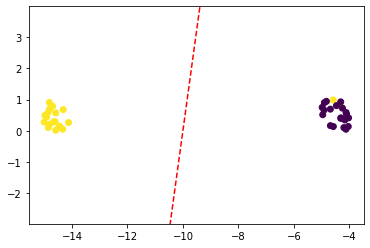

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(1)

class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None


    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

n = 40
X,y=np.zeros((n,2)),np.zeros(n)
X[0:20,0]=np.random.rand(n//2)-15
X[20::,0]=np.random.rand(n//2)-5
X[:,1]=(np.random.rand(n))
X[0:2,0]=X[0:2,0]+10
y[0:20]=np.ones(n//2)
y[20::]=-np.ones(n//2)
clf = SVM()
clf.fit(X, y)
print(clf.w, clf.b)

def visualize_svm():
     def get_hyperplane_value(x, w, b, offset):
          return (-w[0] * x + b + offset) / w[1]
     fig = plt.figure()
     ax = fig.add_subplot(1,1,1)
     plt.scatter(X[:,0], X[:,1], marker='o',c=y)

     x0_1 = np.amin(X[:,0])
     x0_2 = np.amax(X[:,0])

     x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
     x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

     ax.plot([x0_1, x0_2],[x1_1, x1_2], 'r--')
     x1_min = np.amin(X[:,1])
     x1_max = np.amax(X[:,1])
     ax.set_ylim([x1_min-3,x1_max+3])
     plt.show()
visualize_svm()

[[-0.16209737]
 [ 0.05577023]
 [-1.51181337]]


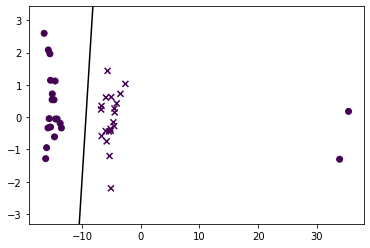

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time
np.random.seed(111)

if __name__ == '__main__':
   start = time.time()

n = 40
x,y=np.zeros((3,n)),np.zeros(n)
x[0,0:20]=np.random.randn(n//2)-15
x[0,20::]=np.random.randn(n//2)-5
x[1,:]=(np.random.randn(n))
y[0:20]=np.ones(n//2)
y[20::]=-np.ones(n//2)
x[0,0:2]=x[0,0:2]+50
x[2,::]=1
l,e=0.0001,0.001
t0=np.zeros((3,1))
for i in range(1000):
    m=np.dot(t0.T,x)*y
    v=m+np.min([np.ones_like(m),np.max([np.zeros_like(m),1-m],axis=0)],axis=0)
    a=np.abs(v-m)
    w=np.ones_like(y)
    for j in range(len(w)):
        if a[0,j]>e:
            w[j]=e/a[0,j]
    w=np.reshape(w,[40,1])
    t1= LA.inv(np.dot(x,(np.repeat(w,3,axis=1).T*x).T))+l*np.eye(3)
    t2=np.dot(x,(w.T*v*y).T)
    t=np.dot(t1,t2)
    if LA.norm(t-t0)<0.1:
        break
    t0=t
print(t)
x1_min = np.amin(x[1,0:20])
x1_max = np.amax(x[1,20::])
z=[-16,5]
plt.scatter(x[0,0:20], x[1,0:20], marker='o',c=y[0:20])
plt.scatter(x[0,20::], x[1,20::], marker='x',c=y[20::])
plt.plot(z,-(t[2]+z*t[0])/t[1],'k-')
plt.ylim([x1_min-2,x1_max+2])
plt.show()


2022-09-26 22:18:22.963970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: module 'tensorflow' has no attribute 'placeholder'

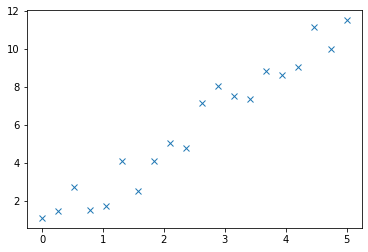

In [4]:

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

class SVR(object):
    def __init__(self, epsilon=0.5):
        self.epsilon = epsilon

    def fit(self, X, y, epochs=100, learning_rate=0.1):
        #self.sess = tf.Session()
        self.sess = tf.compat.v1.Session()

        feature_len = X.shape[-1] if len(X.shape) > 1 else 1

        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        self.X = tf.placeholder(dtype=tf.float32, shape=(None, feature_len))
        self.y = tf.placeholder(dtype=tf.float32, shape=(None, 1))

        self.W = tf.Variable(tf.random_normal(shape=(feature_len, 1)))
        self.b = tf.Variable(tf.random_normal(shape=(1,)))
        self.y_pred = tf.matmul(self.X, self.W) + self.b
        #self.loss = tf.reduce_mean(tf.square(self.y - self.y_pred))
        self.loss = tf.norm(self.W)/2 + tf.reduce_mean(tf.maximum(0., tf.abs(self.y_pred - self.y) - self.epsilon))
        opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        opt_op = opt.minimize(self.loss)

        self.sess.run(tf.global_variables_initializer())

        for i in range(epochs):
            loss = self.sess.run(
                self.loss,
                {
                    self.X: X,
                    self.y: y
                }
            )
            print("{}/{}: loss: {}".format(i + 1, epochs, loss))

            self.sess.run(
                opt_op,
                {
                    self.X: X,
                    self.y: y
                }
            )

        return self

    def predict(self, X, y=None):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)

        y_pred = self.sess.run(
            self.y_pred,
            {
                self.X: X
            }
        )
        return y_pred


x = np.linspace(start=0, stop=5, num=20)


m = 2
c = 1

y = m * x + c

y += np.random.normal(size=(len(y),))


plt.plot(x, y, "x")


model = SVR(epsilon=0.2)


model.fit(x, y)

plt.plot(
    x, y, "x",
    x, model.predict(x), "-"
)
plt.legend(["actual", "prediction"])
plt.show()



